In [1]:
%load_ext autoreload
%autoreload 2
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = 'last_expr'

In [17]:
import configparser

config = configparser.ConfigParser()
config.read('config.ini')
mlflow_uri = config['mlflow']['mlflow_uri']
mlflow_artifact_uri = config['mlflow']['target_mlflow_artifact_uri']

#### MLFlow integration was introduced in version 2.0 so make sure one is running on a correct version of pycaret

In [3]:
import pycaret

print(pycaret.__version__)

2.3.1


In [4]:
# set tracking uri
import mlflow

mlflow.set_tracking_uri(mlflow_uri)

In [5]:
# print(mlflow.get_tracking_uri())
# print(mlflow.get_artifact_uri())

In [6]:
from pycaret.datasets import get_data

dataset_name = 'diamond'
target_var_name = 'Price'
data = get_data(dataset_name)

,Carat Weight,Cut,Color,Clarity,Polish,Symmetry,Report,Price
0,1.10,Ideal,H,SI1,VG,EX,GIA,5169
1,0.83,Ideal,H,VS1,ID,ID,AGSL,3470
2,0.85,Ideal,H,SI1,EX,EX,GIA,3183
3,0.91,Ideal,E,SI1,VG,VG,GIA,4370
4,0.83,Ideal,G,SI1,EX,EX,GIA,3171


In [7]:
from pycaret.regression import *
import os

username = os.getenv('uid')
s = setup(data, target = target_var_name, transform_target = True, log_experiment = True, experiment_name = f'pycaret-{dataset_name}-{username}-exp')

,Description,Value
0,session_id,4817
1,Target,Price
2,Original Data,"(6000, 8)"
3,Missing Values,False
4,Numeric Features,1
5,Categorical Features,6
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(4199, 28)"


In [8]:
# compare all models
# for pycaret.regression sort default is R2
best = compare_models(sort='MAPE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,577.0189,1332263.1414,1141.3680,0.9873,0.0612,0.0448,1.6550
lightgbm,Light Gradient Boosting Machine,645.5318,1821389.6429,1319.6855,0.9830,0.0672,0.0491,0.3290
xgboost,Extreme Gradient Boosting,665.4780,1785351.4000,1324.7883,0.9830,0.0691,0.0510,0.9440
gbr,Gradient Boosting Regressor,754.2496,2277250.2459,1482.1627,0.9787,0.0767,0.0573,0.3500
rf,Random Forest Regressor,744.0416,2408164.9190,1516.9856,0.9777,0.0791,0.0575,1.0020
et,Extra Trees Regressor,751.6727,2420879.5240,1525.1591,0.9774,0.0809,0.0590,1.0240
dt,Decision Tree Regressor,947.9753,3922263.5216,1889.0090,0.9638,0.1029,0.0742,0.0550
ada,AdaBoost Regressor,2005.5381,17263730.9401,4097.8398,0.8401,0.1885,0.1508,0.2880
huber,Huber Regressor,3420.2340,517271695.1896,18071.8813,-3.4449,0.2236,0.1714,0.3070
ridge,Ridge Regression,3359.6176,377692440.8000,16382.4227,-2.3016,0.2216,0.1726,0.0260


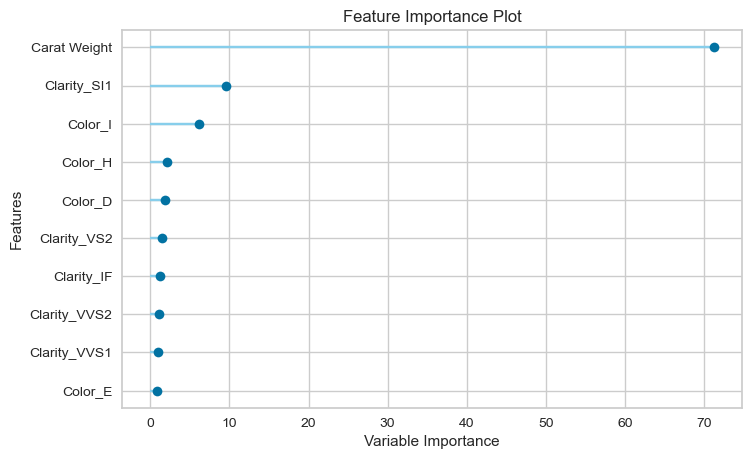

In [16]:
plot_model(best, plot = 'feature')

In [9]:
import shutil

current_artifact_uri = mlflow.get_artifact_uri()
current_artifact_base_fpath = os.path.dirname(os.path.dirname(os.path.dirname(current_artifact_uri)))
# print(f'{current_artifact_base_fpath}')
source_dir = f'{current_artifact_base_fpath}'
target_dir = mlflow_artifact_uri
file_names = os.listdir(source_dir)
shutil.move(os.path.join(source_dir, file_names[0]), target_dir)

'A:\\\\analytics\\\\mlflow_artifacts\\\\mlflow1_11_0\\107'

#### one can view the results on mlflow uri and load the artifact

In [14]:
mlflow_artifact_base_path = os.path.join(target_dir, file_names[0])
best_run_id = '4e5de877885c4dc8b50cc565dbba6e62'
# print(f'{mlflow_artifact_base_path}\\\\{best_run_id}\\\\artifacts\\\\model\\\\model')
pipeline = load_model(f'{mlflow_artifact_base_path}\\\\{best_run_id}\\\\artifacts\\\\model\\\\model')
print(pipeline)

Transformation Pipeline and Model Successfully Loaded
Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=True, features_todrop=[],
                                      id_columns=[], ml_usecase='regression',
                                      numerical_features=[], target='Price',
                                      time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numerical=None,
                                numeric_strategy='...
                ('feature_select', 'passthrough'), ('fix_multi', 'passthrough'),
                ('dfs', 'passthrough'), ('pca', 'passthrough'),
                ['trained_model',
                 PowerTransformedTargetRegressor(border_count=254,
                         

In [15]:
copy_data_without_target = data.copy().drop(target_var_name, axis=1, inplace=True)
y_pred = predict_model(pipeline, data=copy_data_without_target)
y_pred.head()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,539.7343,992841.3358,996.4142,0.9899,0.0591,0.0446


,Carat Weight,Cut_Fair,Cut_Good,Cut_Ideal,Cut_Signature-Ideal,Cut_Very Good,Color_D,Color_E,Color_F,Color_G,...,Polish_G,Polish_ID,Polish_VG,Symmetry_EX,Symmetry_G,Symmetry_ID,Symmetry_VG,Report_GIA,Price,Label
0,2.04,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,18026.0,17131.385030
1,1.51,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,9058.0,9187.950668
2,0.90,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,4466.0,4445.122386
3,0.80,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,3817.0,4231.467184
4,0.92,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,4953.0,4875.371923
